In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns
import tqdm

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

# get properties from this package: https://github.com/ikmckenz/adme-pred-py
from adme_pred import ADME # pip install ADME_predict is NOT the right one
# could not pip or conda install since it is not a package so directly downloaded adme-pred-py into my src folder

# Helper functions

In [2]:
def calculate_physiochem_props(df, smiles_col = 'SMILES'):
    print('Computing physiochem properties...')
    smis = list(df[smiles_col])
    mols = [ADME(smi) for smi in tqdm.tqdm(smis)]
    
    print('Computing drug likeness...')
    df['egan'] = [mol.druglikeness_egan() for mol in mols]
    df['ghose'] = [mol.druglikeness_ghose() for mol in mols]
    df['lipinski'] = [mol.druglikeness_lipinski() for mol in mols]
    df['muegge'] = [mol.druglikeness_muegge() for mol in mols]
    df['brenk'] = [mol.brenk() for mol in mols]
    df['pains'] = [mol.pains() for mol in mols]

    print('Computing bonds and atoms...')
    df['hbond_donor'] = [mol._h_bond_donors() for mol in mols]
    df['hbond_acceptor'] = [mol._h_bond_acceptors() for mol in mols]
    df['MW'] = [mol._molecular_weight() for mol in mols]
    df['n_atoms'] = [mol._n_atoms() for mol in mols]
    df['n_carbons'] = [mol._n_carbons() for mol in mols]
    df['n_heteroatoms'] = [mol._n_heteroatoms() for mol in mols]
    df['n_rings'] = [mol._n_rings() for mol in mols]
    df['n_rot_bonds'] = [mol._n_rot_bonds() for mol in mols]

    print('Computing other properties...')
    df['MR'] = [mol._molar_refractivity() for mol in mols]
    df['logp'] = [mol._logp() for mol in mols]
    df['tpsa'] = [mol._tpsa() for mol in mols]
    return(df)

def plot_physiochem_props(df, plot_path, hit_col = 'hit', ignore_cols = ['Name', 'SMILES']):
    print('Plotting...')
    # compare in each column hits vs non-hits
    numsubplts = len(df.columns) - len(ignore_cols)
    fig, axs = plt.subplots(int(np.ceil(numsubplts / 4)), 4, figsize=(12,20), dpi = 300)
    i_index = 0
    j_index = 0
    for prop in df.columns:
        hits = list(df[df[hit_col] == 1.0][prop])
        nonhits = list(df[df[hit_col] == 0.0][prop])
        smalldf = df[[hit_col, prop]]
        if prop in ignore_cols or prop == hit_col:
            continue
        elif prop in ['egan', 'ghose', 'lipinski', 'muegge', 'brenk', 'pains']:
            test = sp.ttest_ind(hits, nonhits)
            if test[1] < 0.05:
                print('\n' + prop)
                print(test)
            sns.barplot(data = smalldf, x = 'hit', y = prop, ax=axs[i_index,j_index])
            sns.stripplot(data = smalldf, x = 'hit', y = prop, ax=axs[i_index,j_index])

            axs[i_index, j_index].set_title(prop)
            axs[i_index, j_index].legend([],[], frameon=False)
        else:
            test = sp.ttest_ind(hits, nonhits)
            if test[1] < 0.05:
                print('\n' + prop)
                print(test)
            sns.histplot(data = smalldf, x = prop, hue = 'hit', kde = True, stat = 'probability', common_norm = False, ax=axs[i_index,j_index])
            axs[i_index, j_index].set_title(prop)
            #axs[i_index, j_index].legend([],[], frameon=False)
        j_index = j_index + 1
        if j_index > 3:
            j_index = 0
            i_index = i_index + 1
    fig.tight_layout(pad=3.0)
    plt.savefig(plot_path + '.svg')
    plt.savefig(plot_path + '.png')
    plt.show()
    return


In [3]:
def compare_df_and_osheamoser(df, hit_col = 'hit'):
    print('Computing characteristics relative to OShea and Moser...')
    # check differences between o'shea and moser characteristics
    # oshea and moser numbers
    mw = [813, 414] # abx w gram+, then abx w gram-
    clogp = [2.1, -0.1]
    PSA = [243, 165]
    hdonor = [7.1, 5.1]
    hacceptor = [16.3, 9.4]
    osheamoser = [mw, clogp, PSA, hdonor, hacceptor]
    names = ['MW', 'logp', 'tpsa', 'hbond_donor', 'hbond_acceptor']

    columns = ['Group', 'Characteristic', 'Value']
    valdf = []

    # add experimental vals
    for _, cpd in df.iterrows():
        for name in names:
            currval = cpd[name]
            if cpd[hit_col] == 1.0:
                newadd = ['Experimental Hits', name, currval]
            else:
                newadd = ['Experimental Non-Hits', name, currval]
            valdf.append(newadd)

    # add o'shea and moser
    for name, crit in zip(names, osheamoser):
        newadd = ['OShea+Moser Gram+', name, crit[0]]
        valdf.append(newadd)
        newadd = ['OShea+Moser Gram-', name, crit[1]]
        valdf.append(newadd)

    valdf = pd.DataFrame(valdf, columns = columns)
    return(valdf)

def plot_oshea_moser(valdf, plot_path, colors = ['mediumaquamarine','lightgrey','darkgoldenrod','darkgoldenrod']):
    print('Plotting...')
    order = ['Experimental Hits', 'Experimental Non-Hits', 'OShea+Moser Gram+', 'OShea+Moser Gram-']
    my_pal = dict(zip(order,colors))
    g = sns.FacetGrid(valdf, col = 'Characteristic', sharey = False, height=6, aspect=1, margin_titles=True)
    g.map(sns.violinplot, 'Group', 'Value', edgecolor='black', alpha = 0.6, linewidth = 1, ci = 'sd', errcolor = 'black', errwidth = 1.5, capsize = 0.2, saturation = 0.6, palette = my_pal, order = order)
    g.map(sns.stripplot, 'Group', 'Value', dodge = True, edgecolor='black', alpha = 1, linewidth = 1, s = 0.5, palette = my_pal, order = order)

    for ax in g.axes_dict.values():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(plot_path + '.svg')
    plt.savefig(plot_path + '.png')
    plt.show()
    return

# Original PK screen mols: compare hits and non-hits

In [4]:
out_dir = '../figure_panels/'

Computing physiochem properties...


100%|██████████| 1759/1759 [00:00<00:00, 7514.71it/s]


Computing drug likeness...
Computing bonds and atoms...
Computing other properties...
Plotting...

egan
Ttest_indResult(statistic=-5.403893319857233, pvalue=7.412471055940686e-08)

lipinski
Ttest_indResult(statistic=-6.238587809292017, pvalue=5.519760024146484e-10)

muegge
Ttest_indResult(statistic=-2.563684321071397, pvalue=0.010439318477571187)

brenk
Ttest_indResult(statistic=5.00840453092997, pvalue=6.03929246151991e-07)

pains
Ttest_indResult(statistic=2.5751843926225617, pvalue=0.010099802772790399)

hbond_donor
Ttest_indResult(statistic=2.7001760150549132, pvalue=0.006996780688209379)

hbond_acceptor
Ttest_indResult(statistic=7.88004692846106, pvalue=5.6908552049388384e-15)

MW
Ttest_indResult(statistic=7.8688524823642645, pvalue=6.204882009635084e-15)

n_atoms
Ttest_indResult(statistic=7.011635504425205, pvalue=3.346946643337325e-12)

n_carbons
Ttest_indResult(statistic=4.772713591045621, pvalue=1.9680659155564087e-06)

n_heteroatoms
Ttest_indResult(statistic=8.572825845070431,

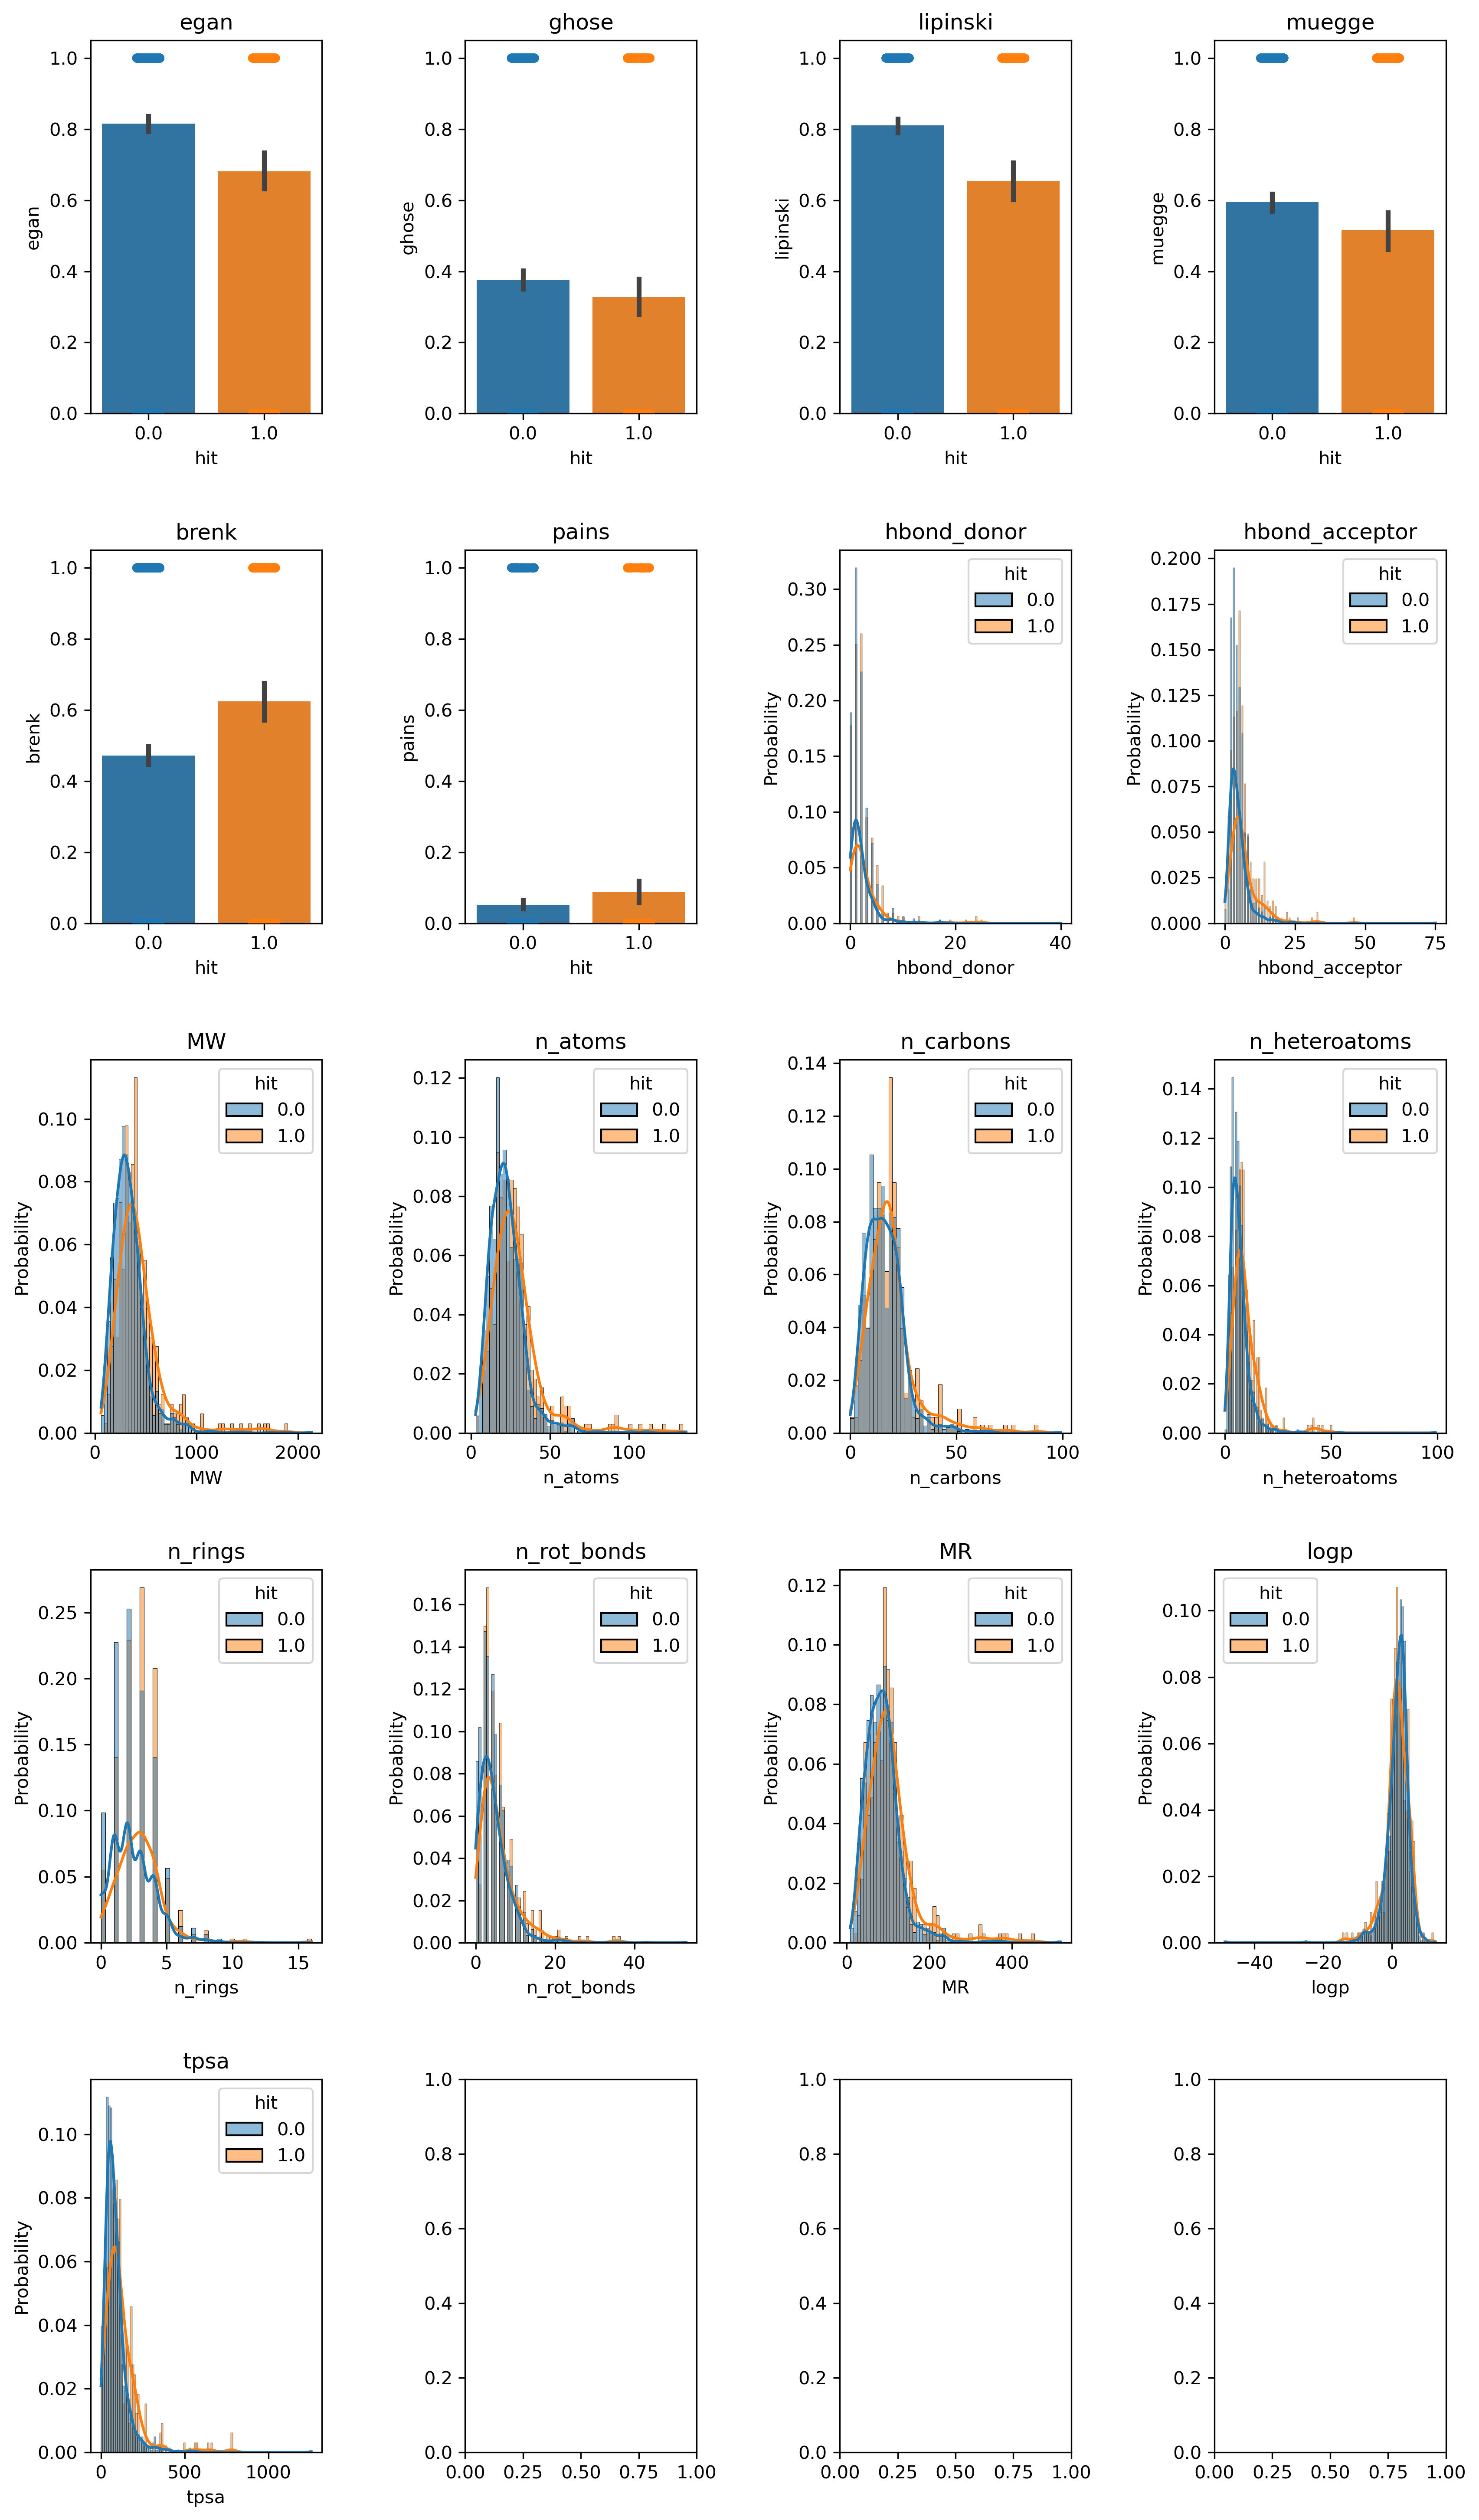

Computing characteristics relative to OShea and Moser...
Plotting...


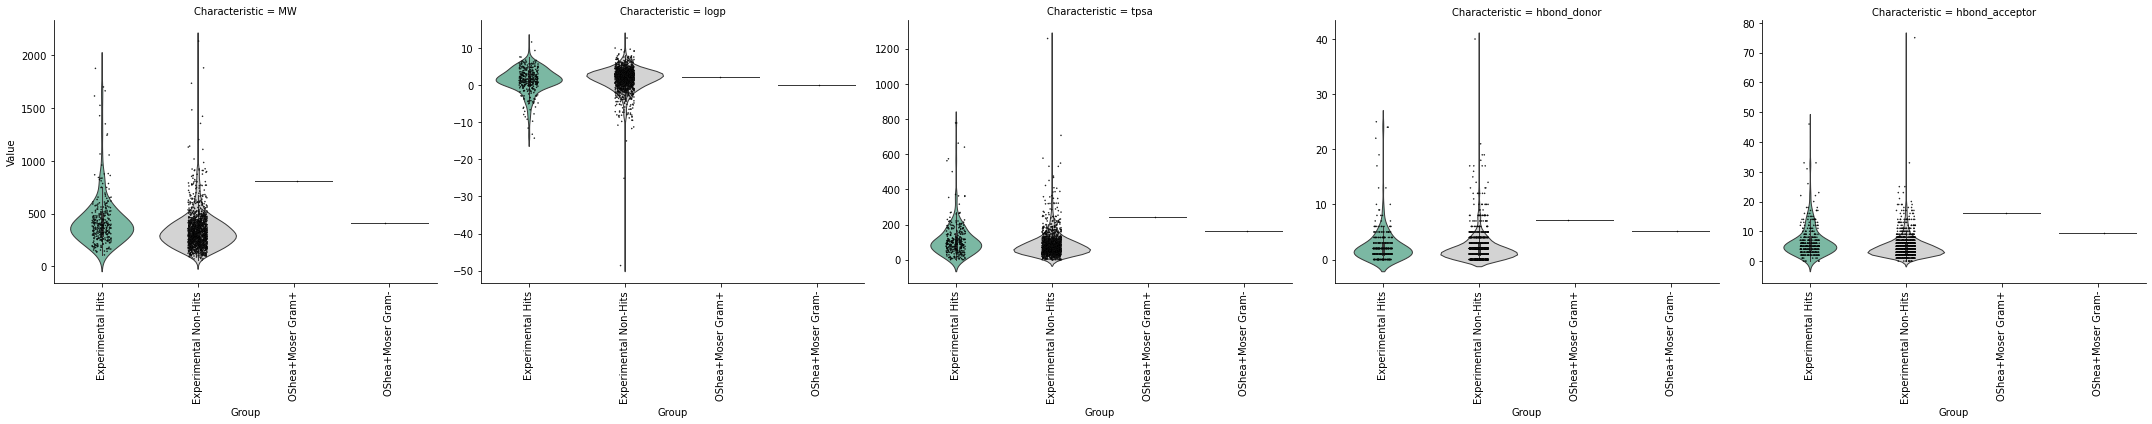

In [5]:
df = pd.read_csv('../data/data_prep_for_ml_pk_screen/FULL_11_15_2021.csv')

df = calculate_physiochem_props(df, smiles_col = 'SMILES')
plot_physiochem_props(df, out_dir + 'PK_physiochem_hits_nonhits', hit_col = 'hit')

valdf = compare_df_and_osheamoser(df, hit_col = 'hit')
plot_oshea_moser(valdf, out_dir + 'PK_osheamoser_hits_nonhits',)

### Takeaways:
There are a lot of properties that are different between the hits and non-hits. On average it looks like the hits are larger (higher MW, number of atoms) and more likely to have Brenk and PAINS alerts than non-hits.

# Combined 37K and PK screen mols: compare hits and non-hits

In [6]:
df = pd.read_csv('../data/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv')

df = calculate_physiochem_props(df, smiles_col = 'SMILES')
plot_physiochem_props(df, out_dir + '37KPK_physiochem_hits_nonhits', hit_col = 'hit')

valdf = compare_df_and_osheamoser(df, hit_col = 'hit')
plot_oshea_moser(valdf, out_dir + '37KPK_osheamoser_hits_nonhits',)

Computing physiochem properties...


100%|██████████| 38680/38680 [00:08<00:00, 4656.56it/s]


Computing drug likeness...


### Takeaways:
Again, a decent number of differences but hits are more likely to have Brenk and PAINS alerts than non-hits.

# Compare correct and incorrect predictions from the PK+37K model that were validated from the 800K+MolPort predictions

Computing physiochem properties...


100%|███████████████████████████████████████████| 94/94 [00:00<00:00, 6455.21it/s]

Computing drug likeness...


Computing bonds and atoms...
Computing other properties...
Plotting...

pains
Ttest_indResult(statistic=2.0484423733989034, pvalue=0.043365904968529344)

hbond_acceptor
Ttest_indResult(statistic=2.5463329167740647, pvalue=0.01254785236723274)

n_heteroatoms
Ttest_indResult(statistic=2.044241781292583, pvalue=0.04378778155355991)

logp
Ttest_indResult(statistic=-2.0569684435072877, pvalue=0.042520331558996705)

tpsa
Ttest_indResult(statistic=2.9773201360114827, pvalue=0.0037163573555880048)


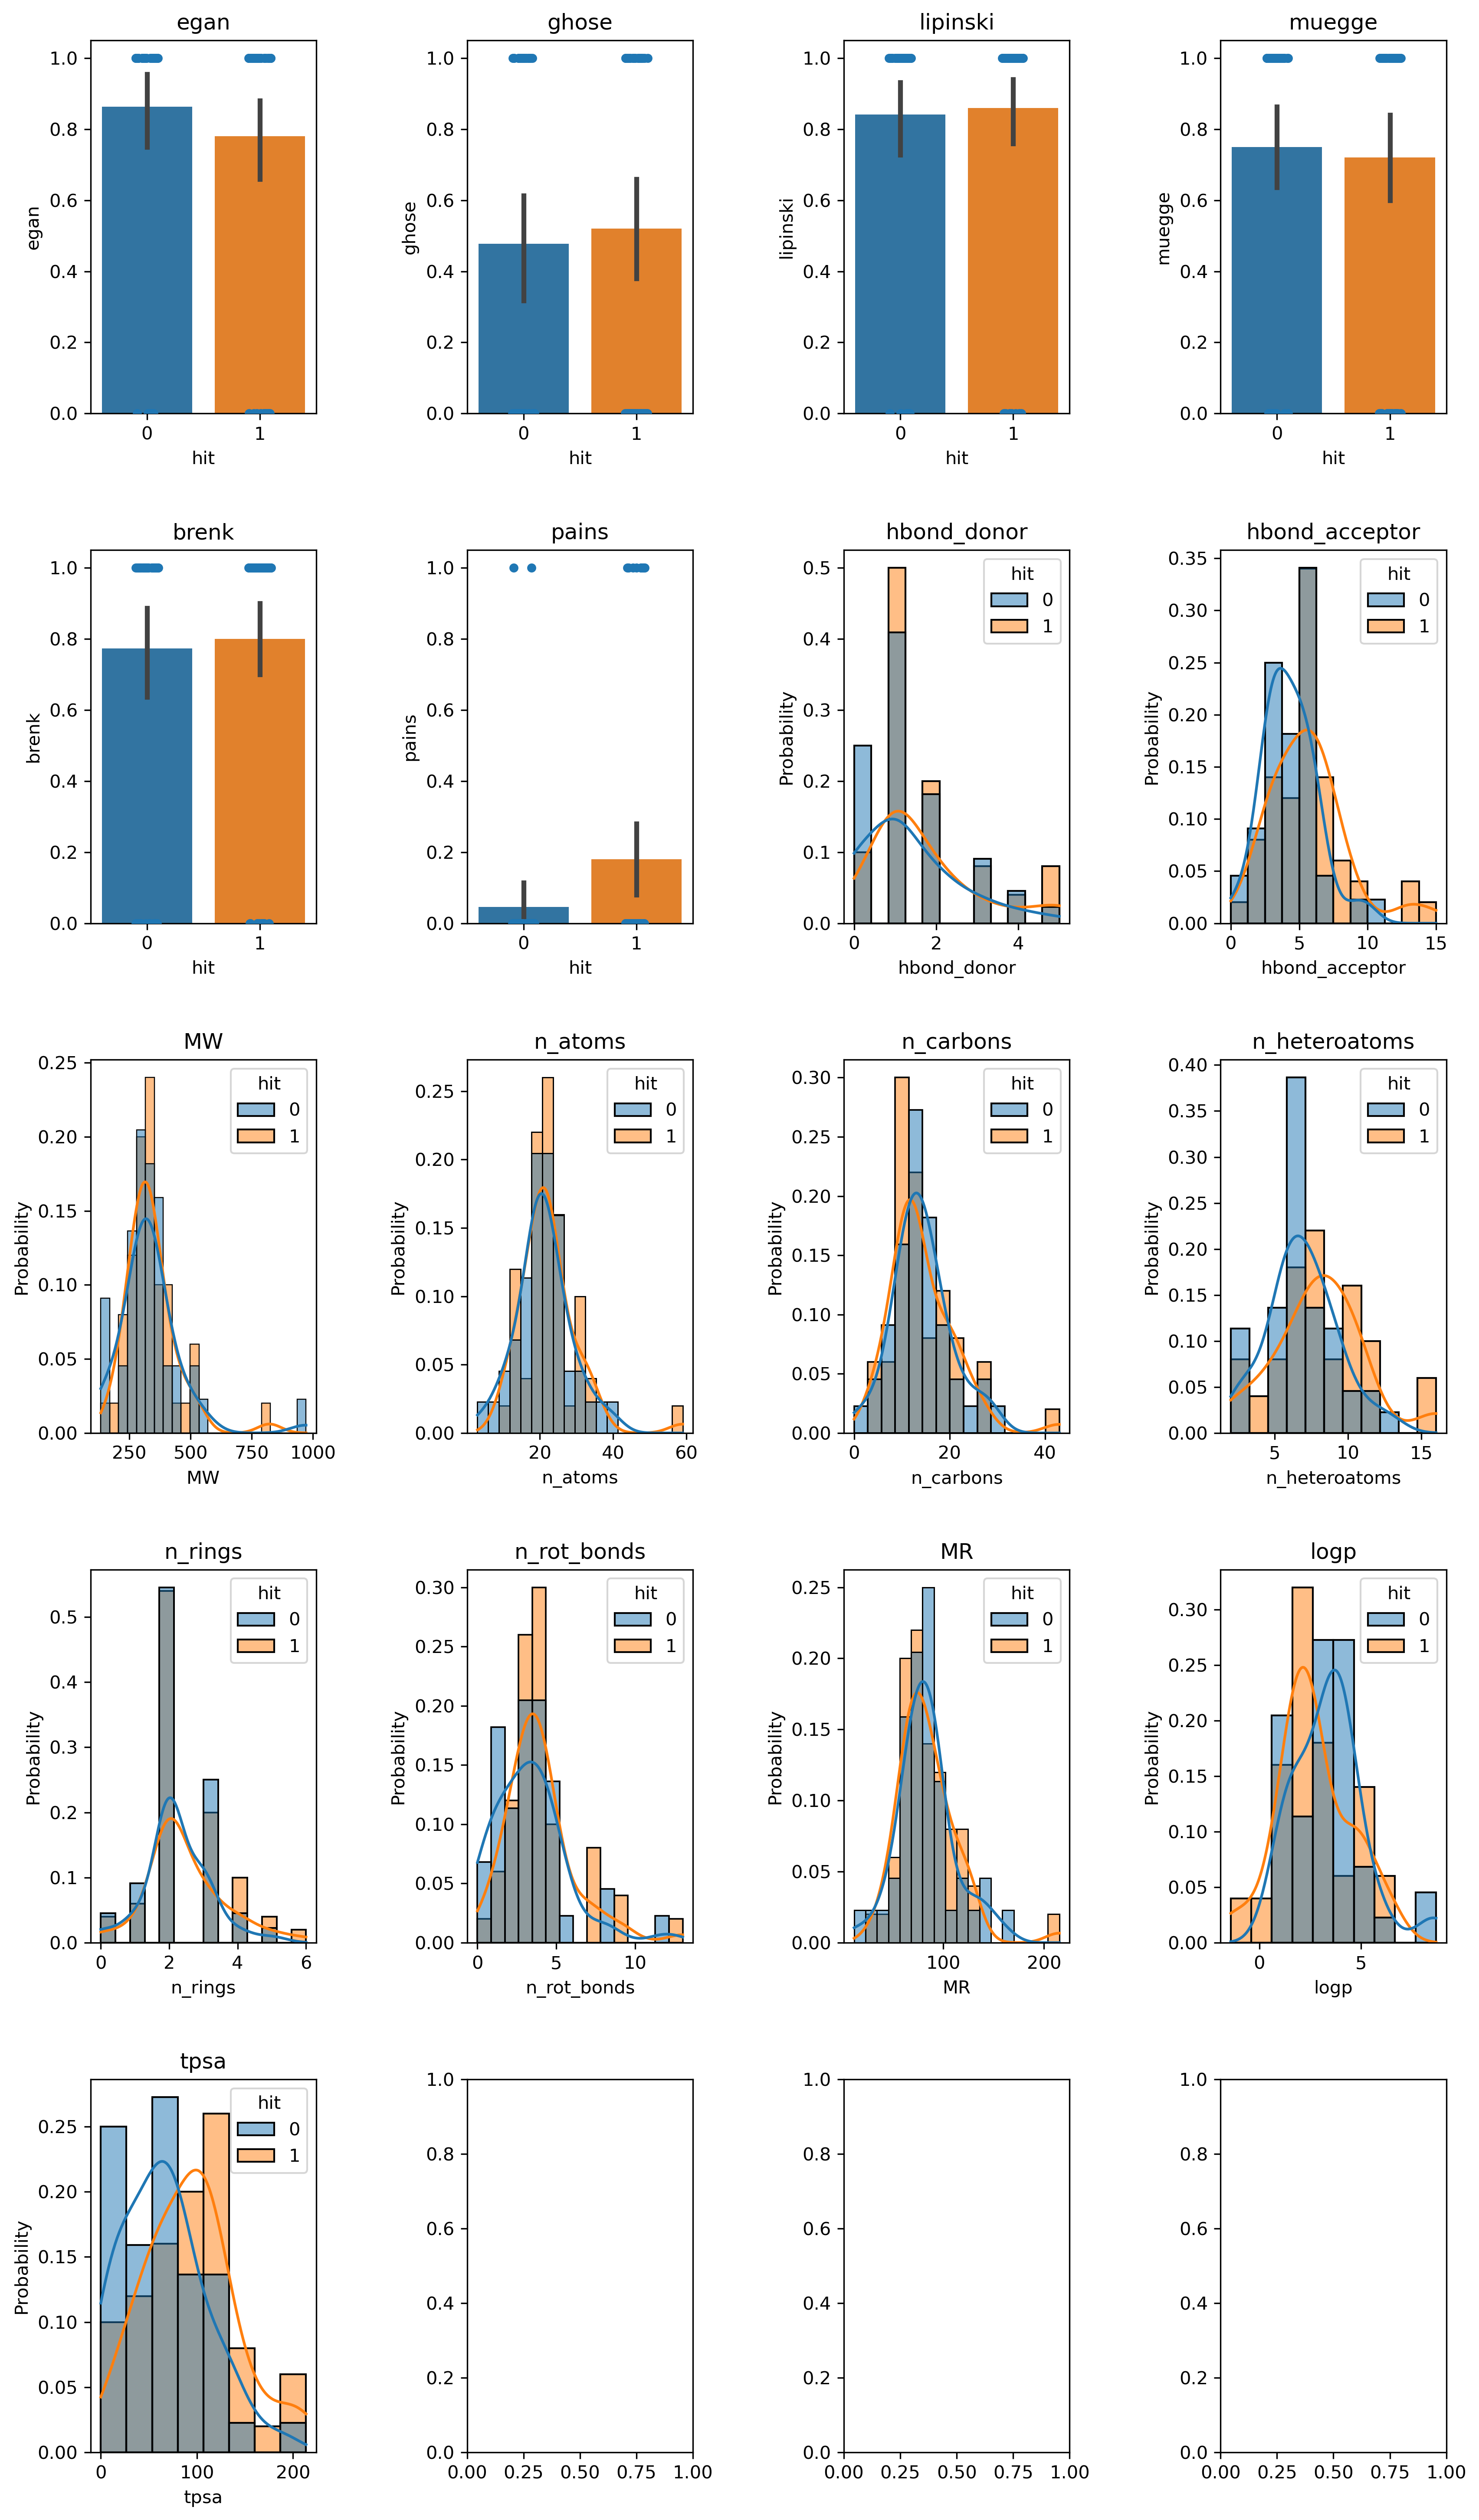

Computing characteristics relative to OShea and Moser...
Plotting...


/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `pa

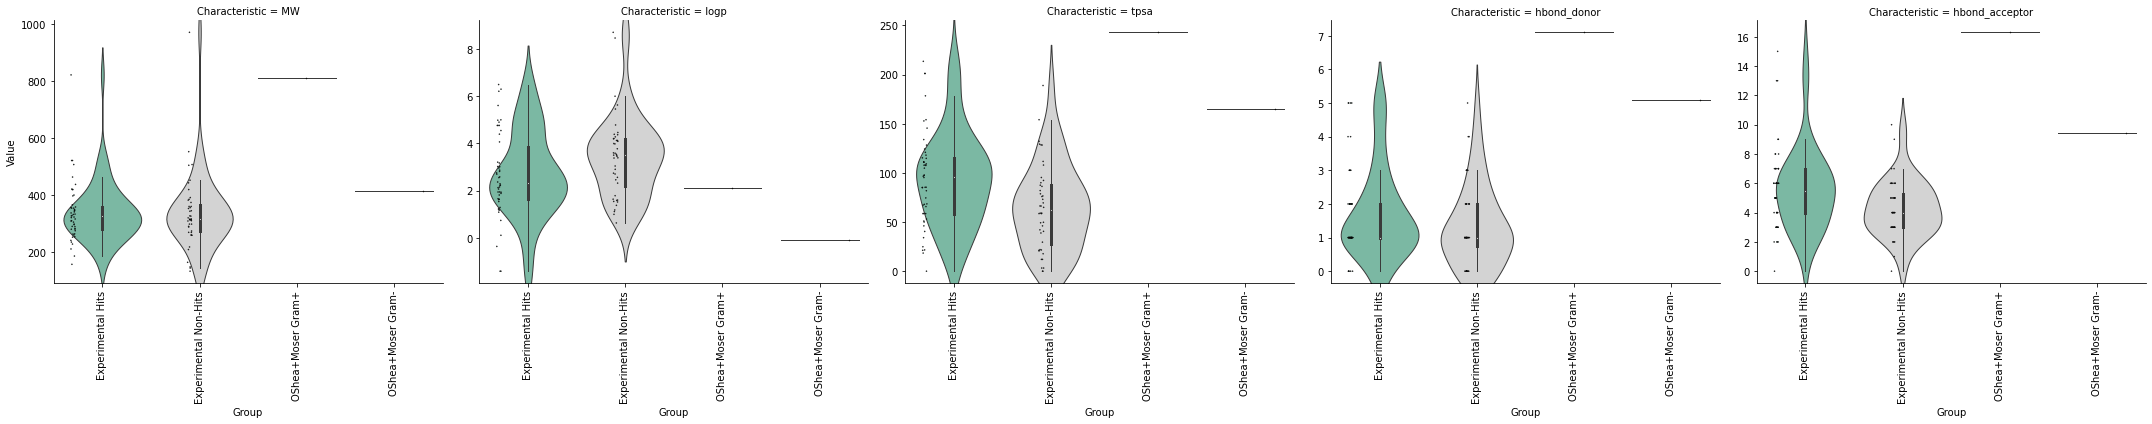

In [5]:
df = pd.read_csv('../data/validated_model_predictions/cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv')

df = calculate_physiochem_props(df, smiles_col = 'SMILES')
plot_physiochem_props(df, out_dir + 'incorrectpreds_physiochem_hits_nonhits', hit_col = 'hit', ignore_cols = ['SMILES', 'name'])

valdf = compare_df_and_osheamoser(df, hit_col = 'hit')
plot_oshea_moser(valdf, out_dir + 'incorrectpreds_osheamoser_hits_nonhits',)

### Takeaways:
This is really compelling! It looks like the model did a significantly better job predicting compounds with a lower logP and higher TPSA. All hits and non-hits here were predicted as high by the GNN, but it seems model predictive capability were worse on compounds with higher logPs and lower TPSAs.